In [4]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
%matplotlib widget

In [6]:
import numpy as np
import matplotlib.pyplot as plt

import mne
from moabb.datasets import BI2013a
from moabb.paradigms import P300


import sys
import os
sys.path.append(os.path.abspath("../.."))
                
from preprocessing.power import field_root_mean_square, plot_fmrs
from preprocessing.data_processing import get_clean_epochs, \
                            Filter, \
                            initialize_weights, apply_weights, \
                            Lagger

In [7]:
dataset=BI2013a()
dataset.subject_list

[1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24]

In [8]:
dir(dataset)

['__abstractmethods__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_abc_impl',
 '_create_process_pipeline',
 '_get_single_subject_data',
 '_get_single_subject_data_using_cache',
 'adaptive',
 'code',
 'data_path',
 'doi',
 'download',
 'event_id',
 'get_data',
 'interval',
 'n_sessions',
 'nonadaptive',
 'online',
 'paradigm',
 'subject_list',
 'training',
 'unit_factor']

In [9]:
dataset.n_sessions

1

In [10]:
epochs = get_clean_epochs(dataset, subjects_list=[1])

Adding metadata with 3 columns
Adding metadata with 3 columns
Adding metadata with 3 columns
Adding metadata with 3 columns
Adding metadata with 3 columns
Adding metadata with 3 columns
Adding metadata with 3 columns
Adding metadata with 3 columns


/nethome/costamai/myenvs/main_env/lib/python3.10/site-packages/moabb/datasets/preprocessing.py:279: UserWarning: warnEpochs <Epochs | 480 events (all good), 0 – 1 s (baseline off), ~30.1 MB, data loaded,
 'Target': 80
 'NonTarget': 400>
  warn(f"warnEpochs {epochs}")
/nethome/costamai/myenvs/main_env/lib/python3.10/site-packages/moabb/datasets/preprocessing.py:279: UserWarning: warnEpochs <Epochs | 480 events (all good), 0 – 1 s (baseline off), ~30.1 MB, data loaded,
 'Target': 80
 'NonTarget': 400>
  warn(f"warnEpochs {epochs}")
/nethome/costamai/myenvs/main_env/lib/python3.10/site-packages/moabb/datasets/preprocessing.py:279: UserWarning: warnEpochs <Epochs | 480 events (all good), 0 – 1 s (baseline off), ~30.1 MB, data loaded,
 'Target': 80
 'NonTarget': 400>
  warn(f"warnEpochs {epochs}")
/nethome/costamai/myenvs/main_env/lib/python3.10/site-packages/moabb/datasets/preprocessing.py:279: UserWarning: warnEpochs <Epochs | 480 events (all good), 0 – 1 s (baseline off), ~30.1 MB, data 

Adding metadata with 3 columns
3840 matching events found
No baseline correction applied
Dataset median value:  -2.3990550088478453e-07


In [11]:
epochs.metadata

subject session run
0           1       1   2
1           1       1   2
2           1       1   2
3           1       1   2
4           1       1   2
...       ...     ...  ..
3834        1       5   2
3835        1       5   2
3836        1       5   2
3837        1       5   2
3838        1       5   2

[2528 rows x 3 columns]

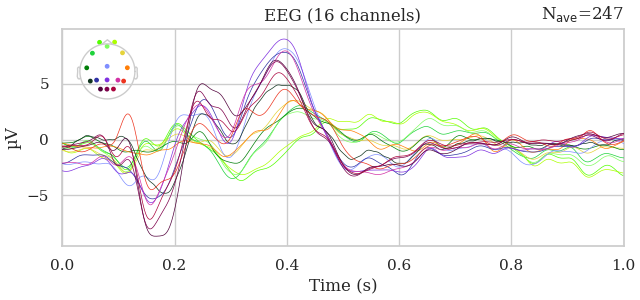

In [12]:
epochs["Target"].average().plot();

No projector specified for this dataset. Please consider the method self.add_proj.


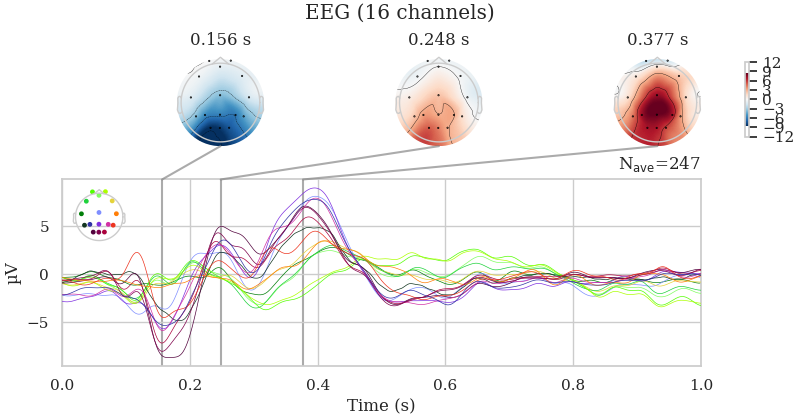

In [13]:
epochs["Target"].average().plot_joint();

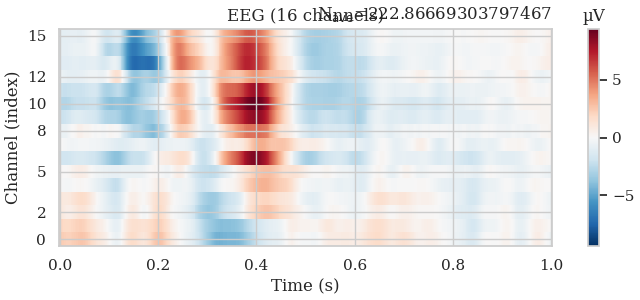

In [14]:
combined_evoked = mne.combine_evoked([epochs["Target"].average(), epochs["NonTarget"].average()], [1,-1])
combined_evoked.plot_image();


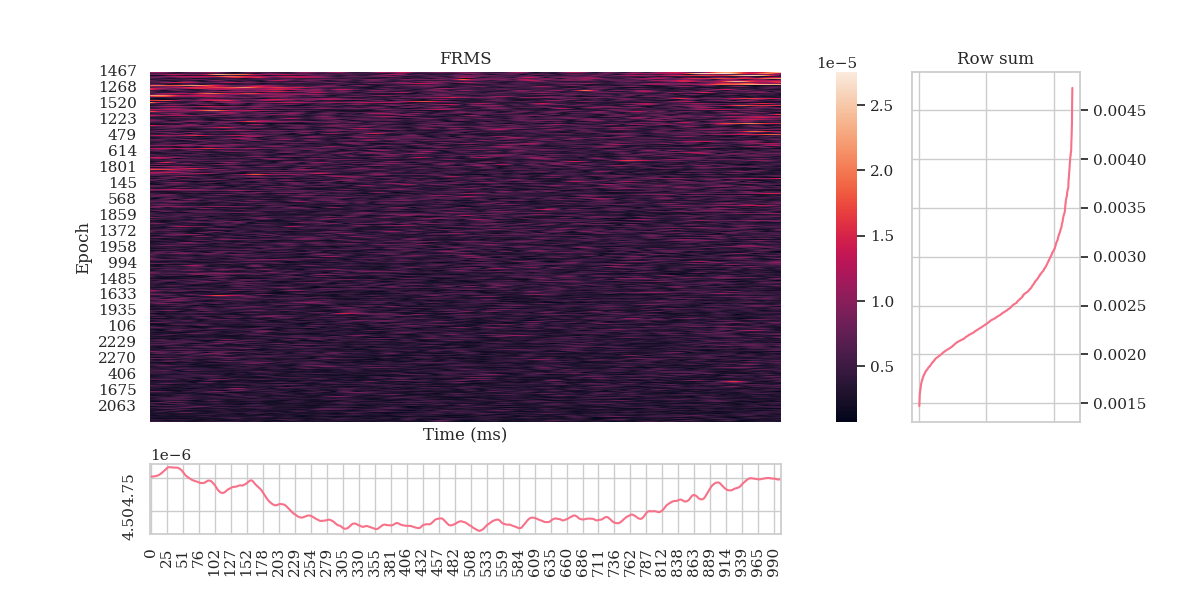

In [15]:
frms = field_root_mean_square(epochs["NonTarget"])
plot_fmrs(frms)

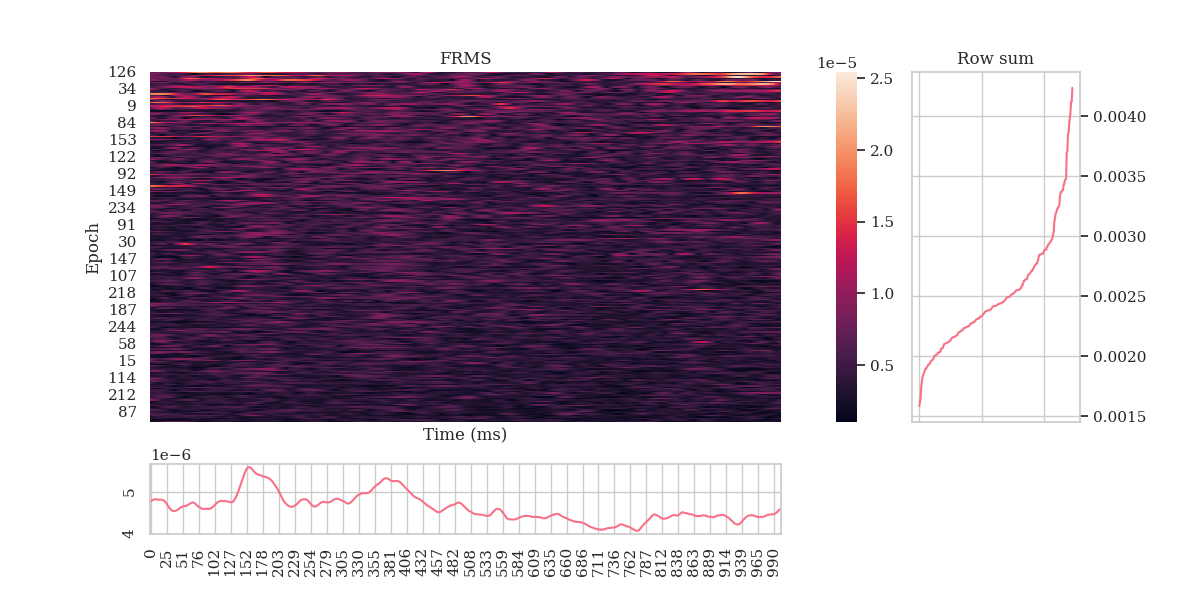

In [16]:
frms = field_root_mean_square(epochs["Target"])
plot_fmrs(frms)

### Apply Spatial Filter

In [17]:
spatial_filter = Filter(epochs=epochs, p=2)
spatial_filter.fit(class_="Target")
filtered_epochs = spatial_filter.apply(epochs=epochs)

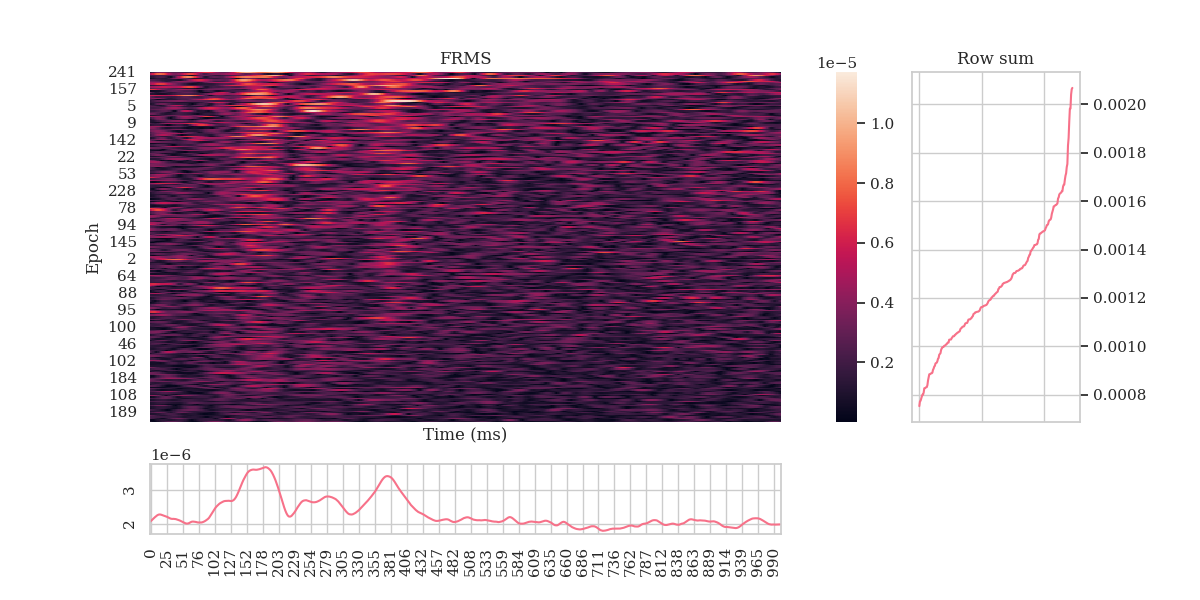

In [18]:
frms = field_root_mean_square(filtered_epochs["Target"])
plot_fmrs(frms)

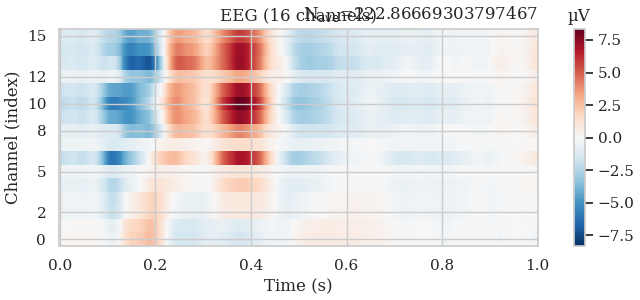

In [19]:
combined_evoked = mne.combine_evoked([filtered_epochs["Target"].average(), filtered_epochs["NonTarget"].average()], [1,-1])
combined_evoked.plot_image();

### Compute and apply Weights

In [20]:
weights_target = initialize_weights(epochs["Target"])
weighted_epochs_target = apply_weights(epochs["Target"], weights_target)
weights_non_target = initialize_weights(epochs["NonTarget"])
weighted_epochs_non_target = apply_weights(epochs["NonTarget"], weights_non_target)

### Compute another spatial filter from scratch to see it gets better

In [21]:
weighted_epochs = mne.concatenate_epochs([weighted_epochs_target, weighted_epochs_non_target])
spatial_filter2 = Filter(epochs=weighted_epochs, p=2)
spatial_filter2.fit(class_="Target")
weighted_filtered_epochs = spatial_filter.apply(epochs=weighted_epochs)

Adding metadata with 3 columns
2528 matching events found
No baseline correction applied


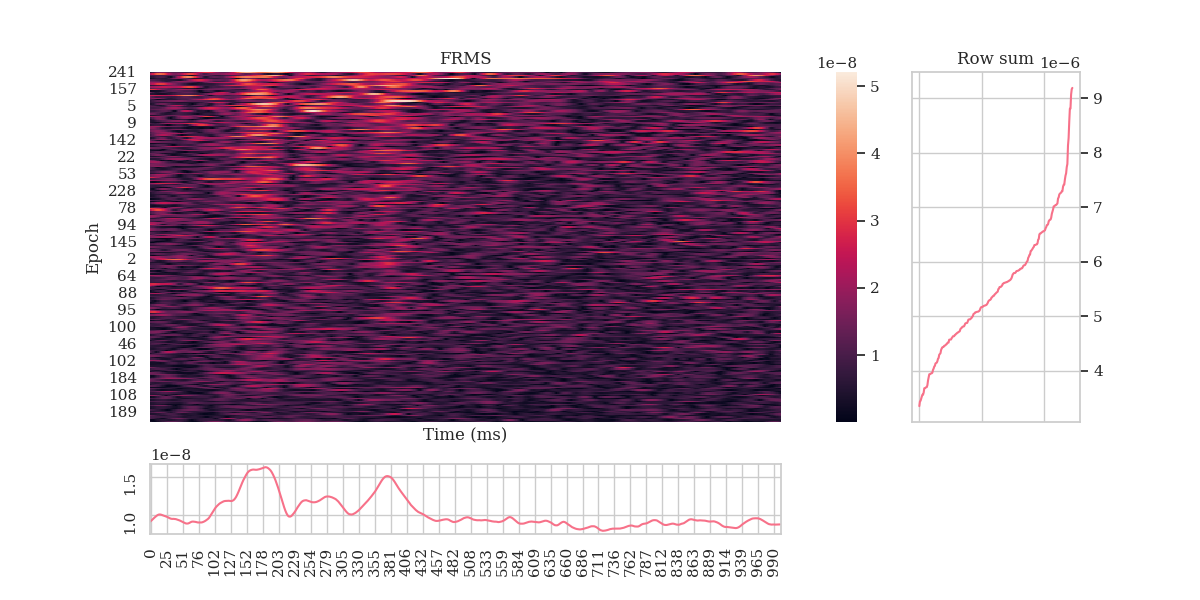

In [22]:
frms = field_root_mean_square(weighted_filtered_epochs["Target"])
plot_fmrs(frms)

### Compute and apply lags

In [23]:
lagger = Lagger(weighted_filtered_epochs["Target"])

In [24]:
lag_corrected_epochs = lagger.compute_and_correct_lags()

Lag corection iteration num:  0


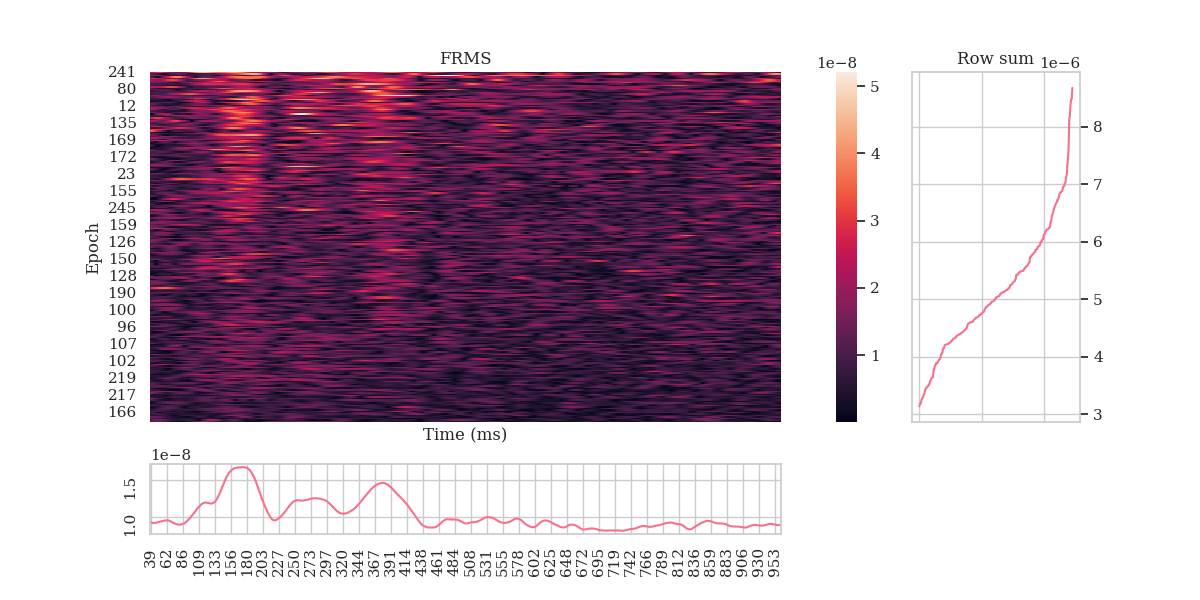

In [25]:
frms = field_root_mean_square(lag_corrected_epochs)
plot_fmrs(frms)

In [26]:
len(lag_corrected_epochs.times), len(epochs.times)

(473, 513)

: 

### Apply Temporal Filter

In [25]:
temporal_filter = Filter(epochs=epochs, p=4, spatial = False)
temporal_filter.fit(class_="Target")
temporal_filtered_epochs = temporal_filter.apply(epochs=epochs)

<class 'mne.epochs.EpochsArray'>


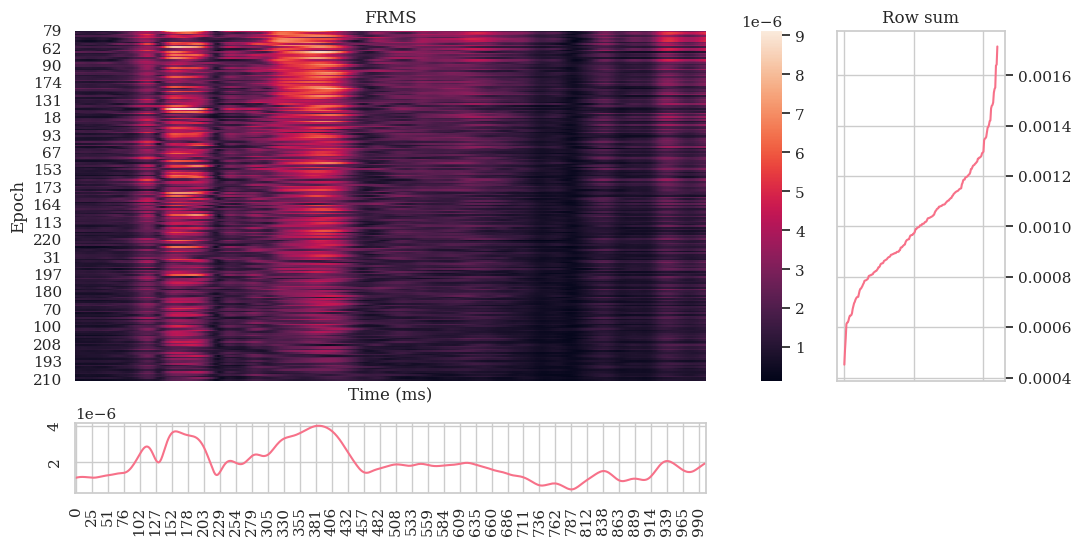

In [26]:
frms = field_root_mean_square(temporal_filtered_epochs["Target"])
plot_fmrs(frms)

No projector specified for this dataset. Please consider the method self.add_proj.


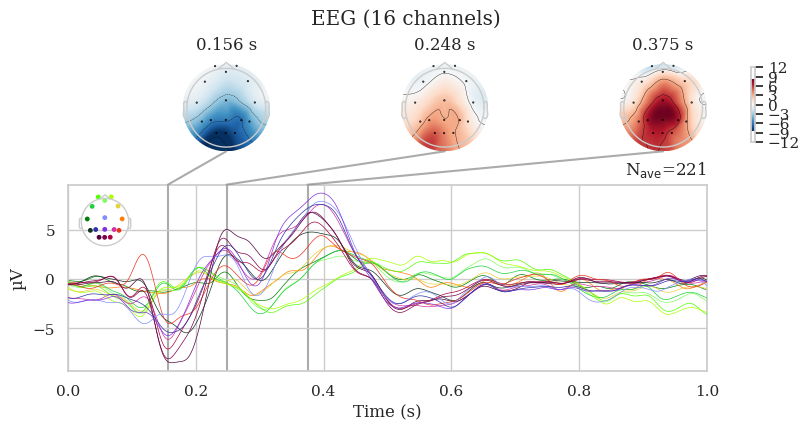

In [22]:
temporal_filtered_epochs["Target"].average().plot_joint();